In [1]:
from sqlalchemy import create_engine
import pandas as pd
import pymorphy2
from nltk import word_tokenize, ngrams
from tqdm.notebook import tqdm
import artm
from matplotlib import pyplot as plt
%matplotlib inline
import re
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import csv
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
from multiprocessing.dummy import Pool as ThreadPool
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

def remove_stopwords(text, check_status=True):
    stop_list = stopwords.words('russian')
    stop_list_2 = [...]
    with open('RussianStopWords.txt', encoding='utf-8') as stops:
        heh = stops.read()
        stop_list_3 = heh.split('\n')
    stops.close()
    set_stop = set(stop_list)
    set_stop.update(stop_list_2)
    set_stop.update(stop_list_3)
    set_stop.update([...])
    locs = pd.read_csv('locs.csv', header=None)
    city_list = list(locs[2])
    set_stop.update(city_list)
    prilag_stops = [...]
    
    morph = pymorphy2.MorphAnalyzer()
    words = []
    if check_status:
        txt_news = tqdm(text)
    else:
        txt_news = text
    for news_proc in txt_news:
        news_proc = word_tokenize(news_proc[0])
        words_lem = []
        for word in news_proc:
            p = morph.parse(word)
            lem = word
            #убираем мусор из стоп-листа и имена с фамилиями
            if word not in set_stop and not ('Surn' in p[0].tag or 'Name' in p[0].tag) and len(lem) > 3:
                if not any(prilag in lem for prilag in prilag_stops):
                    words_lem.append(lem)
        words.append(words_lem)
    return words

def make_bigrams(texts, save=False):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=50)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    if save:
        bigram.save('model/grams/bigrams.phs')
        try:
            bigram.save('model/grams/bigrams.pkl')
        except:
            pass
    print('создаем биграммы')
    return [bigram_mod[doc] for doc in tqdm(texts)]

def make_trigrams(texts, save=False):
    trigram = gensim.models.Phrases(texts, min_count=5, threshold=50)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    if save:
        trigram.save('model/grams/trigrams.phs')
        try:
            trigram.save('model/grams/trigrams.pkl')
        except:
            pass
    print('создаем триграммы')
    return [trigram_mod[doc] for doc in tqdm(texts)]

In [ ]:
bigram = gensim.models.Phrases(text, min_count=5, threshold=50)

In [ ]:
bigram.save('model/grams/bigrams.phs')

In [47]:
with open('model/text_ready_full/text_full.txt', 'w') as tx:
    writer = csv.writer(tx)
    writer.writerows(text)
    tx.close()

In [5]:
engine = create_engine('sqlite:///....db', echo=False)
sqlite_connection = engine.connect()
text = sqlite_connection.execute("SELECT stemmed FROM news_db").fetchall()

In [20]:
text = remove_stopwords(text)

In [21]:
print('биграммы')
text_grams = make_bigrams(text, save=True)
text_grams = make_trigrams(text_grams, save=True)
id2word = corpora.Dictionary(text_grams)

id2word.filter_extremes(no_below=20, no_above=0.7)

corpus = [id2word.doc2bow(txt) for txt in text_grams]
print('сохранение')
pickle.dump(corpus, open('model/corpus_full.pkl', 'wb'))
id2word.save('model/dictionary_full.gensim')
print('модель')

биграммы
создаем биграммы



создаем триграммы



сохранение
модель


ERROR! Session/line number was not unique in database. History logging moved to new session 54



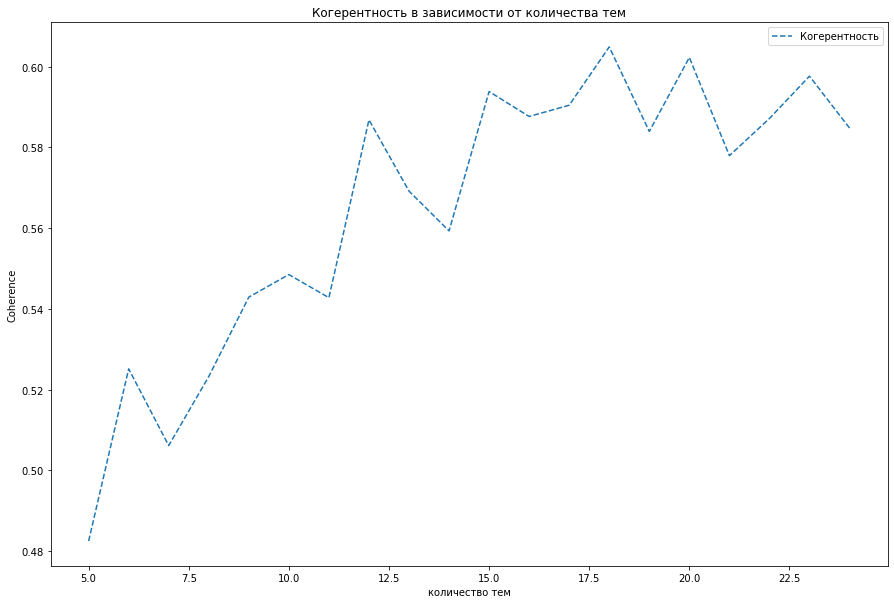

In [24]:
coh_score = []
for i in tqdm(range(5, 25)):
    lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=i,
                         chunksize=1000,
                         passes=5,
                         random_state=100,
                         alpha='symmetric',
                         per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=text_grams, dictionary=id2word, coherence='c_v')
    coh_score.append(coherence_model_lda.get_coherence())
fig = plt.figure(figsize = [15,10])
ax_1 = fig.add_subplot(1, 1, 1)
ax_1.set_title('Когерентность в зависимости от количества тем')
ax_1.set_xlabel('количество тем')
ax_1.set_ylabel('Coherence')
ax_1.plot(range(5, 25), coh_score, linestyle='dashed', label = 'Когерентность')
ax_1.legend()
fig.show()

In [3]:
corpus = pickle.load(open('model/corpus_full.pkl', 'rb'))
id2word = corpora.Dictionary.load(f'model/dictionary_full.gensim')
with open('model/text_ready_full/text_full.txt', 'r', encoding='utf-8') as text_train:
    text_train = text_train.readlines()